# BerlinMOD Examples

This example uses synthetic trip data in Brussels generated by the [MobilityDB-BerlinMOD](https://github.com/MobilityDB/MobilityDB-BerlinMOD) generator to show some data manipulations available in PyMEOS.
It is divided in 5 sections, each corresponding to one MEOS example:
- [Disassembling Trips](https://libmeos.org/tutorialprograms/meos_disassemble_berlinmod/)
- [Clipping Trips to Geometries](https://libmeos.org/tutorialprograms/meos_clip_berlinmod/)
- [Tiling Trips](https://libmeos.org/tutorialprograms/meos_tile_berlinmod/)
- [Simplifying Trips](https://libmeos.org/tutorialprograms/meos_simplify_berlinmod/)
- [Temporal Aggregation of Trips](https://libmeos.org/tutorialprograms/meos_aggregate_berlinmod/)

This example uses the plotting capabilities of PyMEOS. To get the necessary dependencies, you can install pymeos specifying this option:
```shell
pip install pymeos[plot]
```

In [3]:
from functools import partial

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos import *
from pymeos.plotters import TemporalPointSequenceSetPlotter, TemporalPointSequencePlotter
from shapely import wkb

pymeos_initialize()

In every following section we use the data from the BerlinMOD Generator, so we will go ahead and read it.

In [4]:
trips = pd.read_csv('./data/trips.csv',
                    converters={'trip': Temporal.from_hexwkb, 'trajectory': partial(wkb.loads, hex=True)})
trips.head()

vehicle         day  seq                                               trip
0        1  2020-06-01    1  [0101000000A5218194E3211E41EB9B43431A1A5941@20...
1        1  2020-06-01    2  [010100000036A6A116E0F51D410818EC5287315941@20...
2        1  2020-06-02    1  [0101000000A5218194E3211E41EB9B43431A1A5941@20...
3        1  2020-06-02    2  [010100000036A6A116E0F51D410818EC5287315941@20...
4        1  2020-06-03    1  [0101000000A5218194E3211E41EB9B43431A1A5941@20...

## Disassembling Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_disassemble_berlinmod/))

In this section, we disassemble the trips into individual observations and write them in a CSV file ordered by timestamp.

First, we'll obtain every timestamp and value from the trajectory object (`TGeogPointSeq`) using the `timestamps` and `values` functions respectively

In [5]:
records = trips.copy()
records['geom'] = trips['trip'].apply(lambda trip: trip.values(precision=20))
records['t'] = trips['trip'].apply(lambda trip: trip.timestamps)
records.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                trip  \
0  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
1  [010100000036A6A116E0F51D410818EC5287315941@20...   
2  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
3  [010100000036A6A116E0F51D410818EC5287315941@20...   
4  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   

                                                geom  \
0  [POINT (493688.8950238473 6580329.051001529), ...   
1  [POINT (490872.022101018 6604317.295660026), P...   
2  [POINT (493688.8950238473 6580329.051001529), ...   
3  [POINT (490872.022101018 6604317.295660026), P...   
4  [POINT (493688.8950238473 6580329.051001529), ...   

                                                   t  
0  [2020-06-01 09:29:51.360000+02:00, 2020-06-01 ...  
1  [2020-06-01 16:27:01.756000+02:00, 2020-06-01 ...  
2  [2020-06-02 09:59:42.221000+02:00, 2020-06-02 ...  
3  [2020-06-02 16:03:17.800000+02:00, 2020-06-02 ...  
4  [2020-06-03 09:15:24.203000+02:00, 2020-06-03 ...

Now, we drop the original `trip` column and "explode" the `t` and `geom` columns to get a row per record. Then, we sort the records by timestamp.

In [6]:
records = records.drop('trip', axis=1).explode(['geom', 't'], ignore_index=True)
records = records.sort_values('t')
records.head()

vehicle         day  seq                                          geom  \
31227        3  2020-06-01    1  POINT (496102.81365390314 6595154.145011816)   
31228        3  2020-06-01    1  POINT (496105.47466444335 6595158.378098504)   
31229        3  2020-06-01    1  POINT (496107.99001022504 6595162.379464369)   
31230        3  2020-06-01    1  POINT (496119.60063311475 6595162.626321746)   
31231        3  2020-06-01    1  POINT (496117.49669473886 6595135.013606767)   

                                     t  
31227 2020-06-01 08:10:09.852000+02:00  
31228 2020-06-01 08:10:11.352000+02:00  
31229 2020-06-01 08:10:12.202733+02:00  
31230 2020-06-01 08:10:14.293117+02:00  
31231 2020-06-01 08:10:19.277812+02:00

Finally, we will write it in a CSV file, encoding first the geometries as HexWKB

In [7]:
records['geom'] = records['geom'].apply(partial(wkb.dumps, hex=True))
records.head()

vehicle         day  seq                                        geom  \
31227        3  2020-06-01    1  0101000000217D2E419B471E41A4DF478994285941   
31228        3  2020-06-01    1  0101000000936F0EE6A5471E4111C4329895285941   
31229        3  2020-06-01    1  01010000008D3DC5F5AF471E41EC24499896285941   
31230        3  2020-06-01    1  0101000000035E0C67DE471E41CEA715A896285941   
31231        3  2020-06-01    1  0101000000AE8B9DFCD5471E41EBEEDEC08F285941   

                                     t  
31227 2020-06-01 08:10:09.852000+02:00  
31228 2020-06-01 08:10:11.352000+02:00  
31229 2020-06-01 08:10:12.202733+02:00  
31230 2020-06-01 08:10:14.293117+02:00  
31231 2020-06-01 08:10:19.277812+02:00

In [8]:
records.to_csv('./trip_instants2.csv', index=False)

## Clipping Trips to Geometries ([MEOS Example](https://libmeos.org/tutorialprograms/meos_clip_berlinmod/))

In this section, we compute the distance traversed by the trips in the 19 [Brussels municipalities](https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region) (communes in French)

First, we will read the files containing the information about the Brussels region and its municipalities and take a look at their shape

In [9]:
brussels = pd.read_csv('../data/brussels_region.csv', converters={'geom': partial(wkb.loads, hex=True)})
brussels = gpd.GeoDataFrame(brussels, geometry='geom')
brussels_geom = brussels['geom'][0]
brussels

name  \
0  Région de Bruxelles-Capitale - Brussels Hoofds...   

                                                geom  
0  POLYGON ((472413.848 6589441.686, 472482.354 6...

In [10]:
communes = pd.read_csv('../data/communes.csv', converters={'geom': partial(wkb.loads, hex=True)})
communes['color'] = ['#00ff00', '#ff00ff', '#007fff', '#ff7f00', '#7fbf7f', '#47139e', '#ad0414', '#d981f9', '#138014',
                     '#f4fc2c', '#00ffff', '#00ff7f', '#c04d7c', '#85eaf3', '#85d601', '#fca880', '#0000ff', '#019d92',
                     '#907817']
communes = gpd.GeoDataFrame(communes, geometry='geom')
communes

id                                           name  population  \
0    1                                     Anderlecht      118241   
1    2                           Auderghem - Oudergem       33313   
2    3    Berchem-Sainte-Agathe - Sint-Agatha-Berchem       24701   
3    4                                      Etterbeek      176545   
4    5                                          Evere       47414   
5    6                                 Forest - Vorst       40394   
6    7                                      Ganshoren       55746   
7    8                               Ixelles - Elsene       24596   
8    9                                          Jette       86244   
9   10                                     Koekelberg       51933   
10  11     Molenbeek-Saint-Jean - Sint-Jans-Molenbeek       21609   
11  12                     Saint-Gilles - Sint-Gillis       96629   
12  13    Saint-Josse-ten-Noode - Sint-Joost-ten-Node       50471   
13  14                        Schaerbeek - Schaarbeek       27115   
14  15                                  Uccle - Ukkel      133042   
15  16              Ville de Bruxelles - Stad Brussel       82307   
16  17      Watermael-Boitsfort - Watermaal-Bosvoorde       24871   
17  18  Woluwe-Saint-Lambert - Sint-Lambrechts-Woluwe       55216   
18  19      Woluwe-Saint-Pierre - Sint-Pieters-Woluwe       41217   

                                                 geom    color  
0   POLYGON ((476959.746 6593981.357, 476965.401 6...  #00ff00  
1   POLYGON ((497620.844 6584185.646, 497856.652 6...  #ff00ff  
2   POLYGON ((477788.720 6599192.996, 477782.631 6...  #007fff  
3   POLYGON ((489804.602 6593678.230, 489685.067 6...  #ff7f00  
4   POLYGON ((492771.667 6597070.173, 492633.519 6...  #7fbf7f  
5   POLYGON ((479909.268 6585570.952, 479881.003 6...  #47139e  
6   POLYGON ((478477.209 6600450.089, 478499.863 6...  #ad0414  
7   MULTIPOLYGON (((487496.626 6592340.790, 487544...  #d981f9  
8   POLYGON ((481479.217 6597749.534, 481526.350 6...  #138014  
9   POLYGON ((480236.024 6597825.520, 480178.160 6...  #f4fc2c  
10  POLYGON ((477542.960 6595837.350, 477533.621 6...  #00ffff  
11  POLYGON ((483153.140 6593066.827, 483122.204 6...  #00ff7f  
12  POLYGON ((485033.738 6596581.156, 484882.700 6...  #c04d7c  
13  POLYGON ((488501.707 6600305.815, 488394.028 6...  #85eaf3  
14  POLYGON ((486268.683 6588562.809, 486253.744 6...  #85d601  
15  POLYGON ((483153.140 6593066.827, 483186.758 6...  #fca880  
16  POLYGON ((491240.935 6581131.551, 491340.822 6...  #0000ff  
17  POLYGON ((496682.744 6594589.884, 496653.033 6...  #019d92  
18  POLYGON ((496135.453 6589271.827, 496258.928 6...  #907817

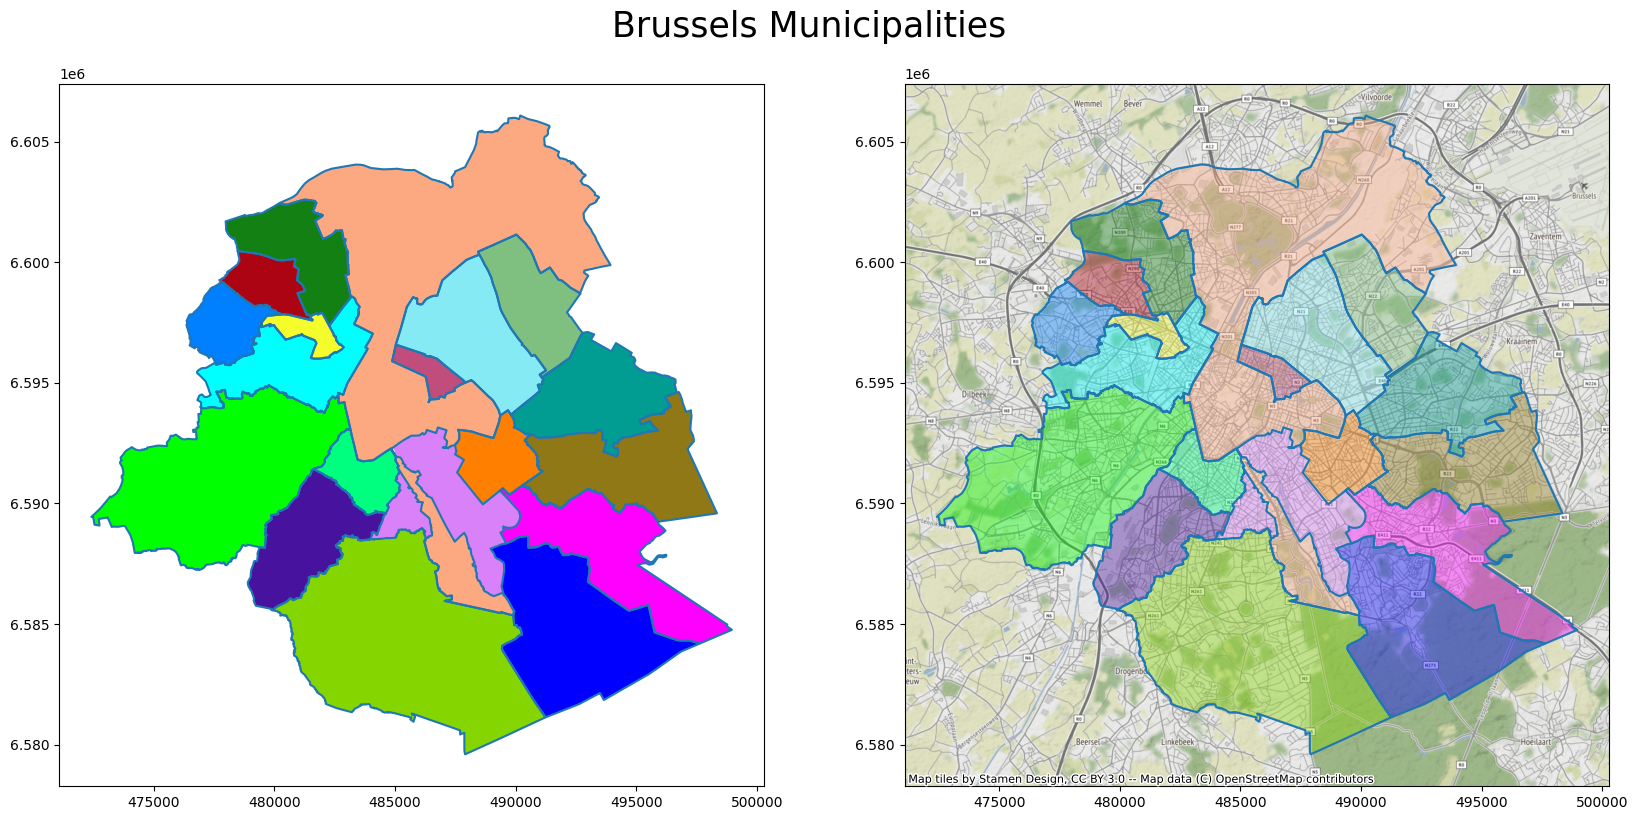

In [11]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
communes.plot(color=communes['color'], ax=axes[0])
communes.exterior.plot(ax=axes[0])
communes.plot(color=communes['color'], ax=axes[1], alpha=0.4)
communes.exterior.plot(ax=axes[1])
cx.add_basemap(axes[1])
_ = plt.suptitle('Brussels Municipalities', size=25, y=0.92)

Now, let's take a look at the BerlinMOD trajectories plotted over Brussels

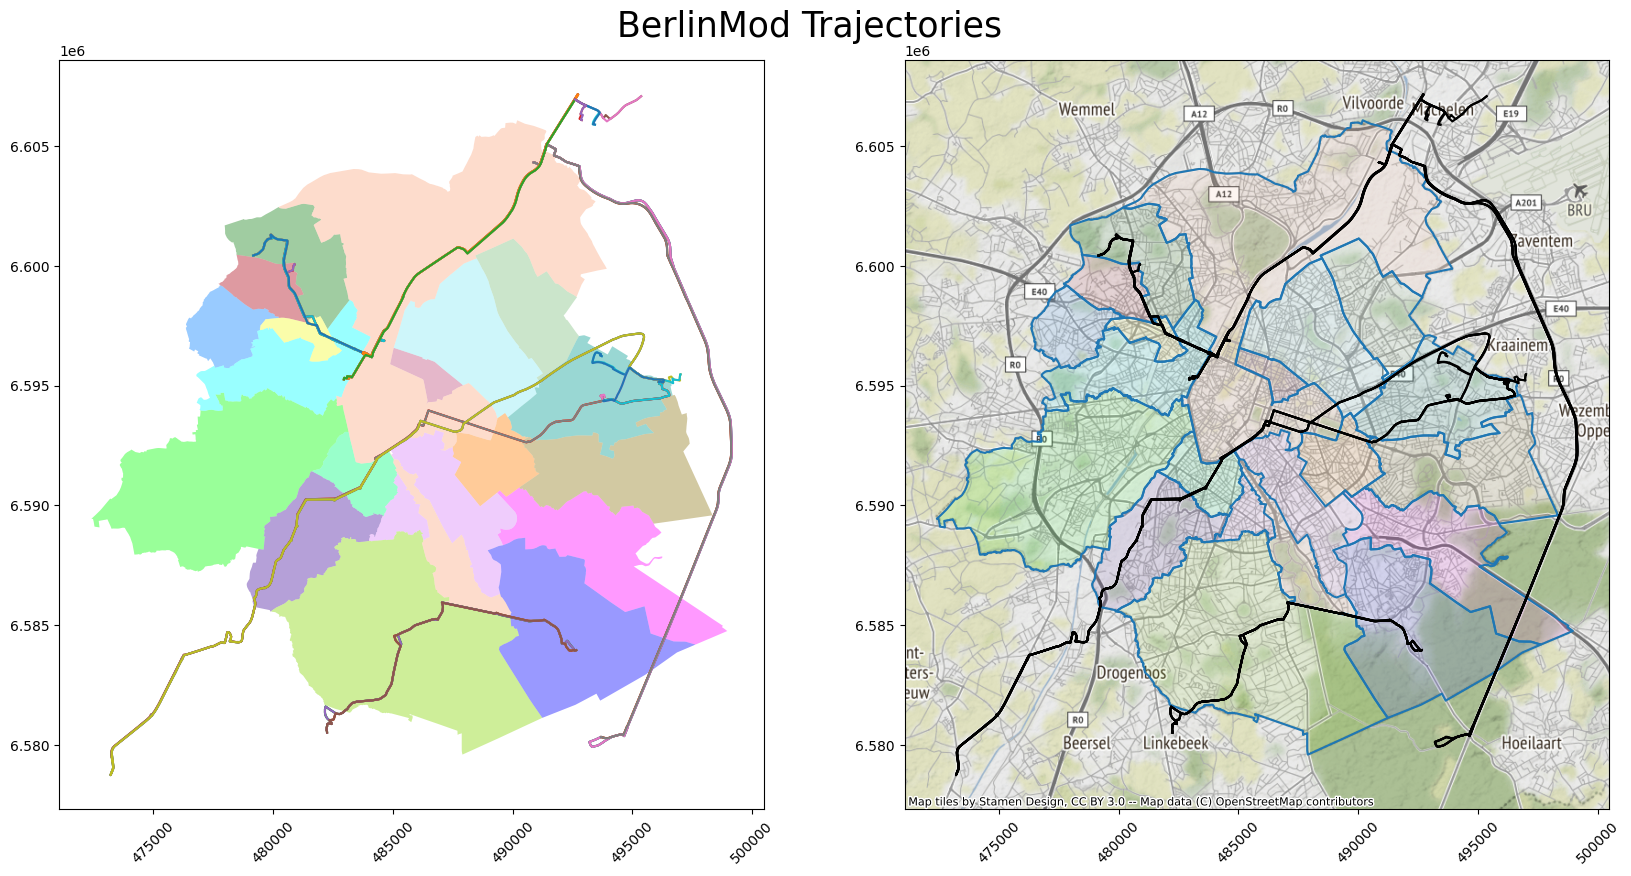

In [12]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
communes.plot(color=communes['color'], ax=axes[0], alpha=0.4)

TemporalPointSequencePlotter.plot_sequences_xy(trips['trip'], axes=axes[0], show_markers=False, show_grid=False)

communes.plot(color=communes['color'], ax=axes[1], alpha=0.1)
communes.exterior.plot(ax=axes[1])
TemporalPointSequencePlotter.plot_sequences_xy(trips['trip'], axes=axes[1], color='black', show_markers=False,
                                               show_grid=False)
cx.add_basemap(axes[1])

_ = plt.suptitle('BerlinMod Trajectories', size=25, y=0.92)

First, let's split the trajectories into sections inside and outside of Brussels

In [13]:
brussels_inout_trajectories = trips.copy()
brussels_inout_trajectories['inside'] = brussels_inout_trajectories['trip'].apply(lambda trip: trip.at(brussels_geom))
brussels_inout_trajectories['outside'] = brussels_inout_trajectories['trip'].apply(
    lambda trip: trip.minus(brussels_geom))
brussels_inout_trajectories.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                trip  \
0  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
1  [010100000036A6A116E0F51D410818EC5287315941@20...   
2  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
3  [010100000036A6A116E0F51D410818EC5287315941@20...   
4  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   

                                              inside  \
0  {[0101000000AE79007A5F421E41BF84E7F6CB1C5941@2...   
1  {[010100000036A6A116E0F51D410818EC5287315941@2...   
2  {[0101000000AE79007A5F421E41BF84E7F6CB1C5941@2...   
3  {[010100000036A6A116E0F51D410818EC5287315941@2...   
4  {[0101000000AE79007A5F421E41BF84E7F6CB1C5941@2...   

                                             outside  
0  {[0101000000A5218194E3211E41EB9B43431A1A5941@2...  
1  {(01010000008F3B6F0F4BFD1D4101C521C6FB315941@2...  
2  {[0101000000A5218194E3211E41EB9B43431A1A5941@2...  
3  {(0101000000615F6F0F4BFD1D4149CB21C6FB315941@2...  
4  {[0101000000A5218194E3211E41EB9B43431A1A5941@2...

Let's see this split in a plot

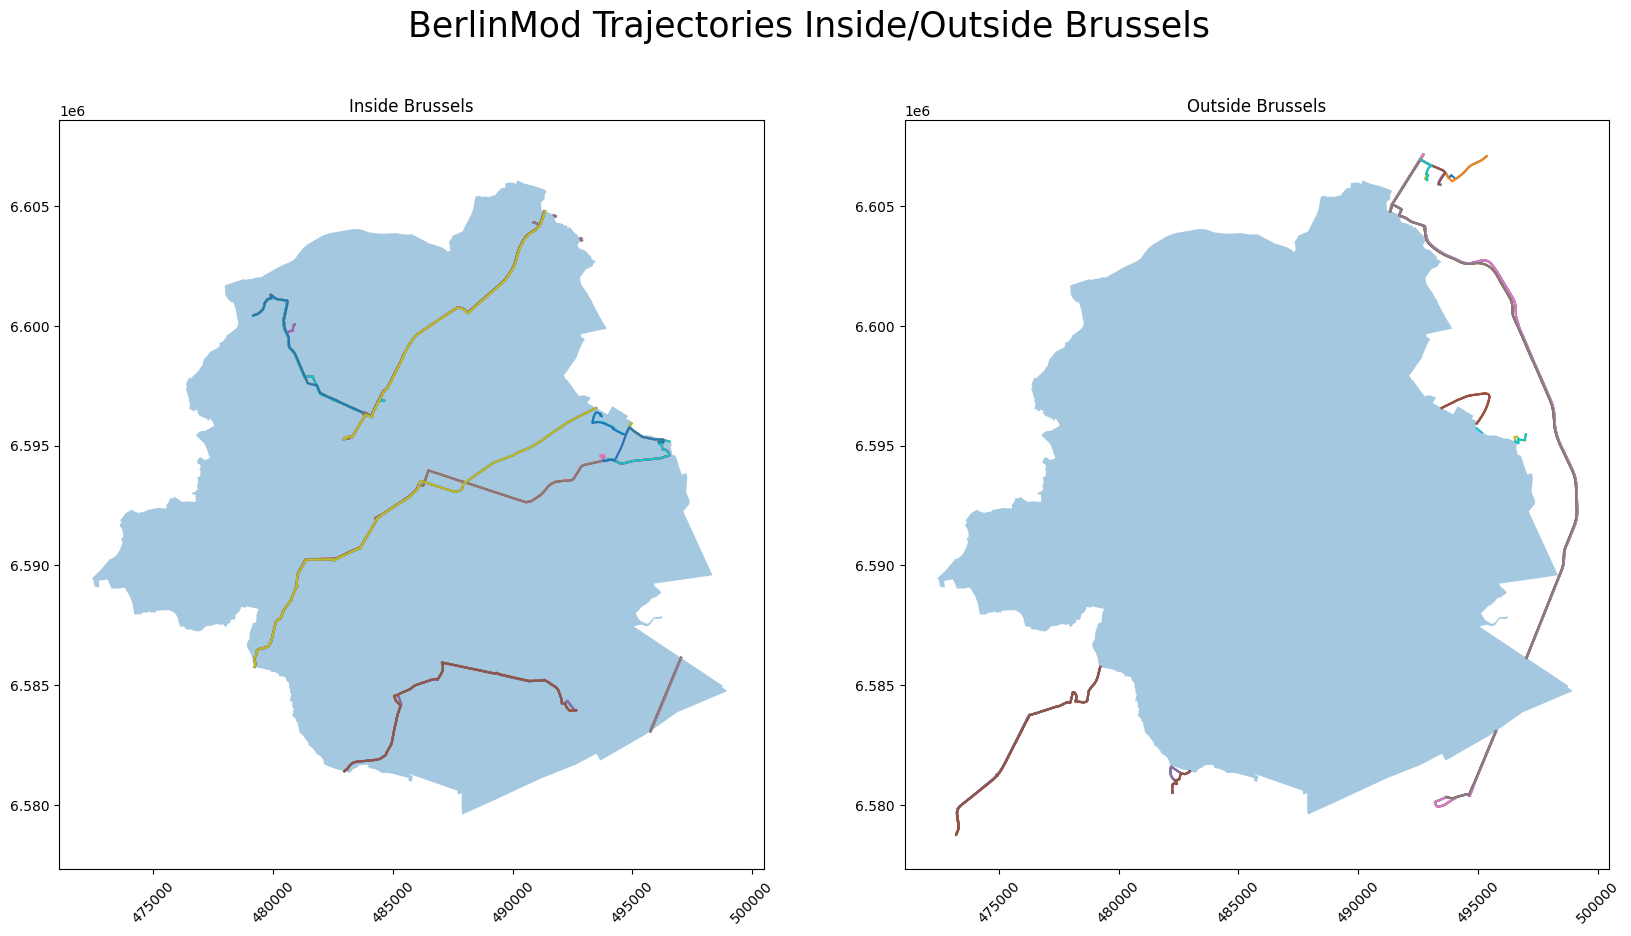

In [14]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].set_title('Inside Brussels')
brussels.plot(ax=axes[0], alpha=0.4)
for tr in brussels_inout_trajectories['inside'].dropna():
    if isinstance(tr, TGeomPointSeq):
        TemporalPointSequencePlotter.plot_xy(tr, axes=axes[0], show_markers=False, show_grid=False)
    else:
        TemporalPointSequenceSetPlotter.plot_xy(tr, axes=axes[0], show_markers=False, show_grid=False)

axes[1].set_title('Outside Brussels')
brussels.plot(ax=axes[1], alpha=0.4)
for tr in brussels_inout_trajectories['outside'].dropna():
    if isinstance(tr, TGeomPointSeq):
        TemporalPointSequencePlotter.plot_xy(tr, axes=axes[1], show_markers=False, show_grid=False)
    else:
        TemporalPointSequenceSetPlotter.plot_xy(tr, axes=axes[1], show_markers=False, show_grid=False)

axes[0].set_xlim(min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]))
axes[0].set_ylim(min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]), max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))

_ = plt.suptitle('BerlinMod Trajectories Inside/Outside Brussels', size=25)

Now we will compute the trajectory and distance each trip traverses in each municipality

In [15]:
commune_trajectories = trips.copy()
for _, row in communes.iterrows():
    commune_trajectories[f'{row["name"]}-trajectory'] = commune_trajectories['trip'].apply(
        lambda trip: trip.at(row['geom']))
    commune_trajectories[f'{row["name"]}-distance'] = commune_trajectories[f'{row["name"]}-trajectory'].apply(
        lambda trip: trip.length() if trip else 0)
commune_trajectories.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                trip Anderlecht-trajectory  \
0  [0101000000A5218194E3211E41EB9B43431A1A5941@20...                  None   
1  [010100000036A6A116E0F51D410818EC5287315941@20...                  None   
2  [0101000000A5218194E3211E41EB9B43431A1A5941@20...                  None   
3  [010100000036A6A116E0F51D410818EC5287315941@20...                  None   
4  [0101000000A5218194E3211E41EB9B43431A1A5941@20...                  None   

   Anderlecht-distance                    Auderghem - Oudergem-trajectory  \
0                    0  {[010100000009149723624B1E419A71B8E3201E5941@2...   
1                    0  {[0101000000D8BB0633FE551E411E74320DC81F5941@2...   
2                    0  {[010100000000F39523624B1E41C645B8E3201E5941@2...   
3                    0  {[0101000000EEBA0633FE551E41FA73320DC81F5941@2...   
4                    0  {[0101000000BAF29623624B1E418C6CB8E3201E5941@2...   

   Auderghem - Oudergem-distance  \
0                    1821.331086   
1                    1825.035072   
2                    1821.331083   
3                    1825.035072   
4                    1821.331073   

  Berchem-Sainte-Agathe - Sint-Agatha-Berchem-trajectory  \
0                                               None       
1                                               None       
2                                               None       
3                                               None       
4                                               None       

   Berchem-Sainte-Agathe - Sint-Agatha-Berchem-distance  ...  \
0                                                  0     ...   
1                                                  0     ...   
2                                                  0     ...   
3                                                  0     ...   
4                                                  0     ...   

  Uccle - Ukkel-trajectory  Uccle - Ukkel-distance  \
0                     None                     0.0   
1                     None                     0.0   
2                     None                     0.0   
3                     None                     0.0   
4                     None                     0.0   

        Ville de Bruxelles - Stad Brussel-trajectory  \
0  {[0101000000EF6D4F6A81151E4108B6607BD0305941@2...   
1  {[010100000036A6A116E0F51D410818EC5287315941@2...   
2  {[0101000000EF6D4F6A81151E4108B6607BD0305941@2...   
3  {[010100000036A6A116E0F51D410818EC5287315941@2...   
4  {[0101000000EF6D4F6A81151E4108B6607BD0305941@2...   

   Ville de Bruxelles - Stad Brussel-distance  \
0                                  994.051093   
1                                 1061.742485   
2                                  994.051088   
3                                 1061.742475   
4                                  994.051093   

  Watermael-Boitsfort - Watermaal-Bosvoorde-trajectory  \
0  {[0101000000AE79007A5F421E41BF84E7F6CB1C5941@2...     
1  {[010100000061FDEE160F4B1E4140A2B1AB221E5941@2...     
2  {[0101000000AE79007A5F421E41BF84E7F6CB1C5941@2...     
3  {[010100000061FDEE160F4B1E4140A2B1AB221E5941@2...     
4  {[0101000000AE79007A5F421E41BF84E7F6CB1C5941@2...     

   Watermael-Boitsfort - Watermaal-Bosvoorde-distance  \
0                                        1480.676391    
1                                        1498.069800    
2                                        1480.676380    
3                                        1498.069800    
4                                        1480.676390    

  Woluwe-Saint-Lambert - Sint-Lambrechts-Woluwe-trajectory  \
0                                               None         
1                                               None         
2                                               None         
3                       

In [16]:
distances = commune_trajectories[['vehicle', 'day', 'seq', *(f'{commune}-distance' for commune in communes['name'])]]
distances.head()

vehicle         day  seq  Anderlecht-distance  \
0        1  2020-06-01    1                    0   
1        1  2020-06-01    2                    0   
2        1  2020-06-02    1                    0   
3        1  2020-06-02    2                    0   
4        1  2020-06-03    1                    0   

   Auderghem - Oudergem-distance  \
0                    1821.331086   
1                    1825.035072   
2                    1821.331083   
3                    1825.035072   
4                    1821.331073   

   Berchem-Sainte-Agathe - Sint-Agatha-Berchem-distance  Etterbeek-distance  \
0                                                  0                    0.0   
1                                                  0                    0.0   
2                                                  0                    0.0   
3                                                  0                    0.0   
4                                                  0                    0.0   

   Evere-distance  Forest - Vorst-distance  Ganshoren-distance  ...  \
0               0                      0.0                 0.0  ...   
1               0                      0.0                 0.0  ...   
2               0                      0.0                 0.0  ...   
3               0                      0.0                 0.0  ...   
4               0                      0.0                 0.0  ...   

   Koekelberg-distance  Molenbeek-Saint-Jean - Sint-Jans-Molenbeek-distance  \
0                  0.0                                                0.0     
1                  0.0                                                0.0     
2                  0.0                                                0.0     
3                  0.0                                                0.0     
4                  0.0                                                0.0     

   Saint-Gilles - Sint-Gillis-distance  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   

   Saint-Josse-ten-Noode - Sint-Joost-ten-Node-distance  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   Schaerbeek - Schaarbeek-distance  Uccle - Ukkel-distance  \
0                               0.0                     0.0   
1                               0.0                     0.0   
2                               0.0                     0.0   
3                               0.0                     0.0   
4                               0.0                     0.0   

   Ville de Bruxelles - Stad Brussel-distance  \
0                                  994.051093   
1                                 1061.742485   
2                                  994.051088   
3                                 1061.742475   
4                                  994.051093   

   Watermael-Boitsfort - Watermaal-Bosvoorde-distance  \
0                                        1480.676391    
1                                        1498.069800    
2                                        1480.676380    
3                                        1498.069800    
4                                        1480.676390    

   Woluwe-Saint-Lambert - Sint-Lambrechts-Woluwe-distance  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                0.0        

   Woluwe-Saint-Pierre - Sint-Pieters-Woluwe-distance  
0                                               

Finally, let's see the visualization of the trajectories split by commune

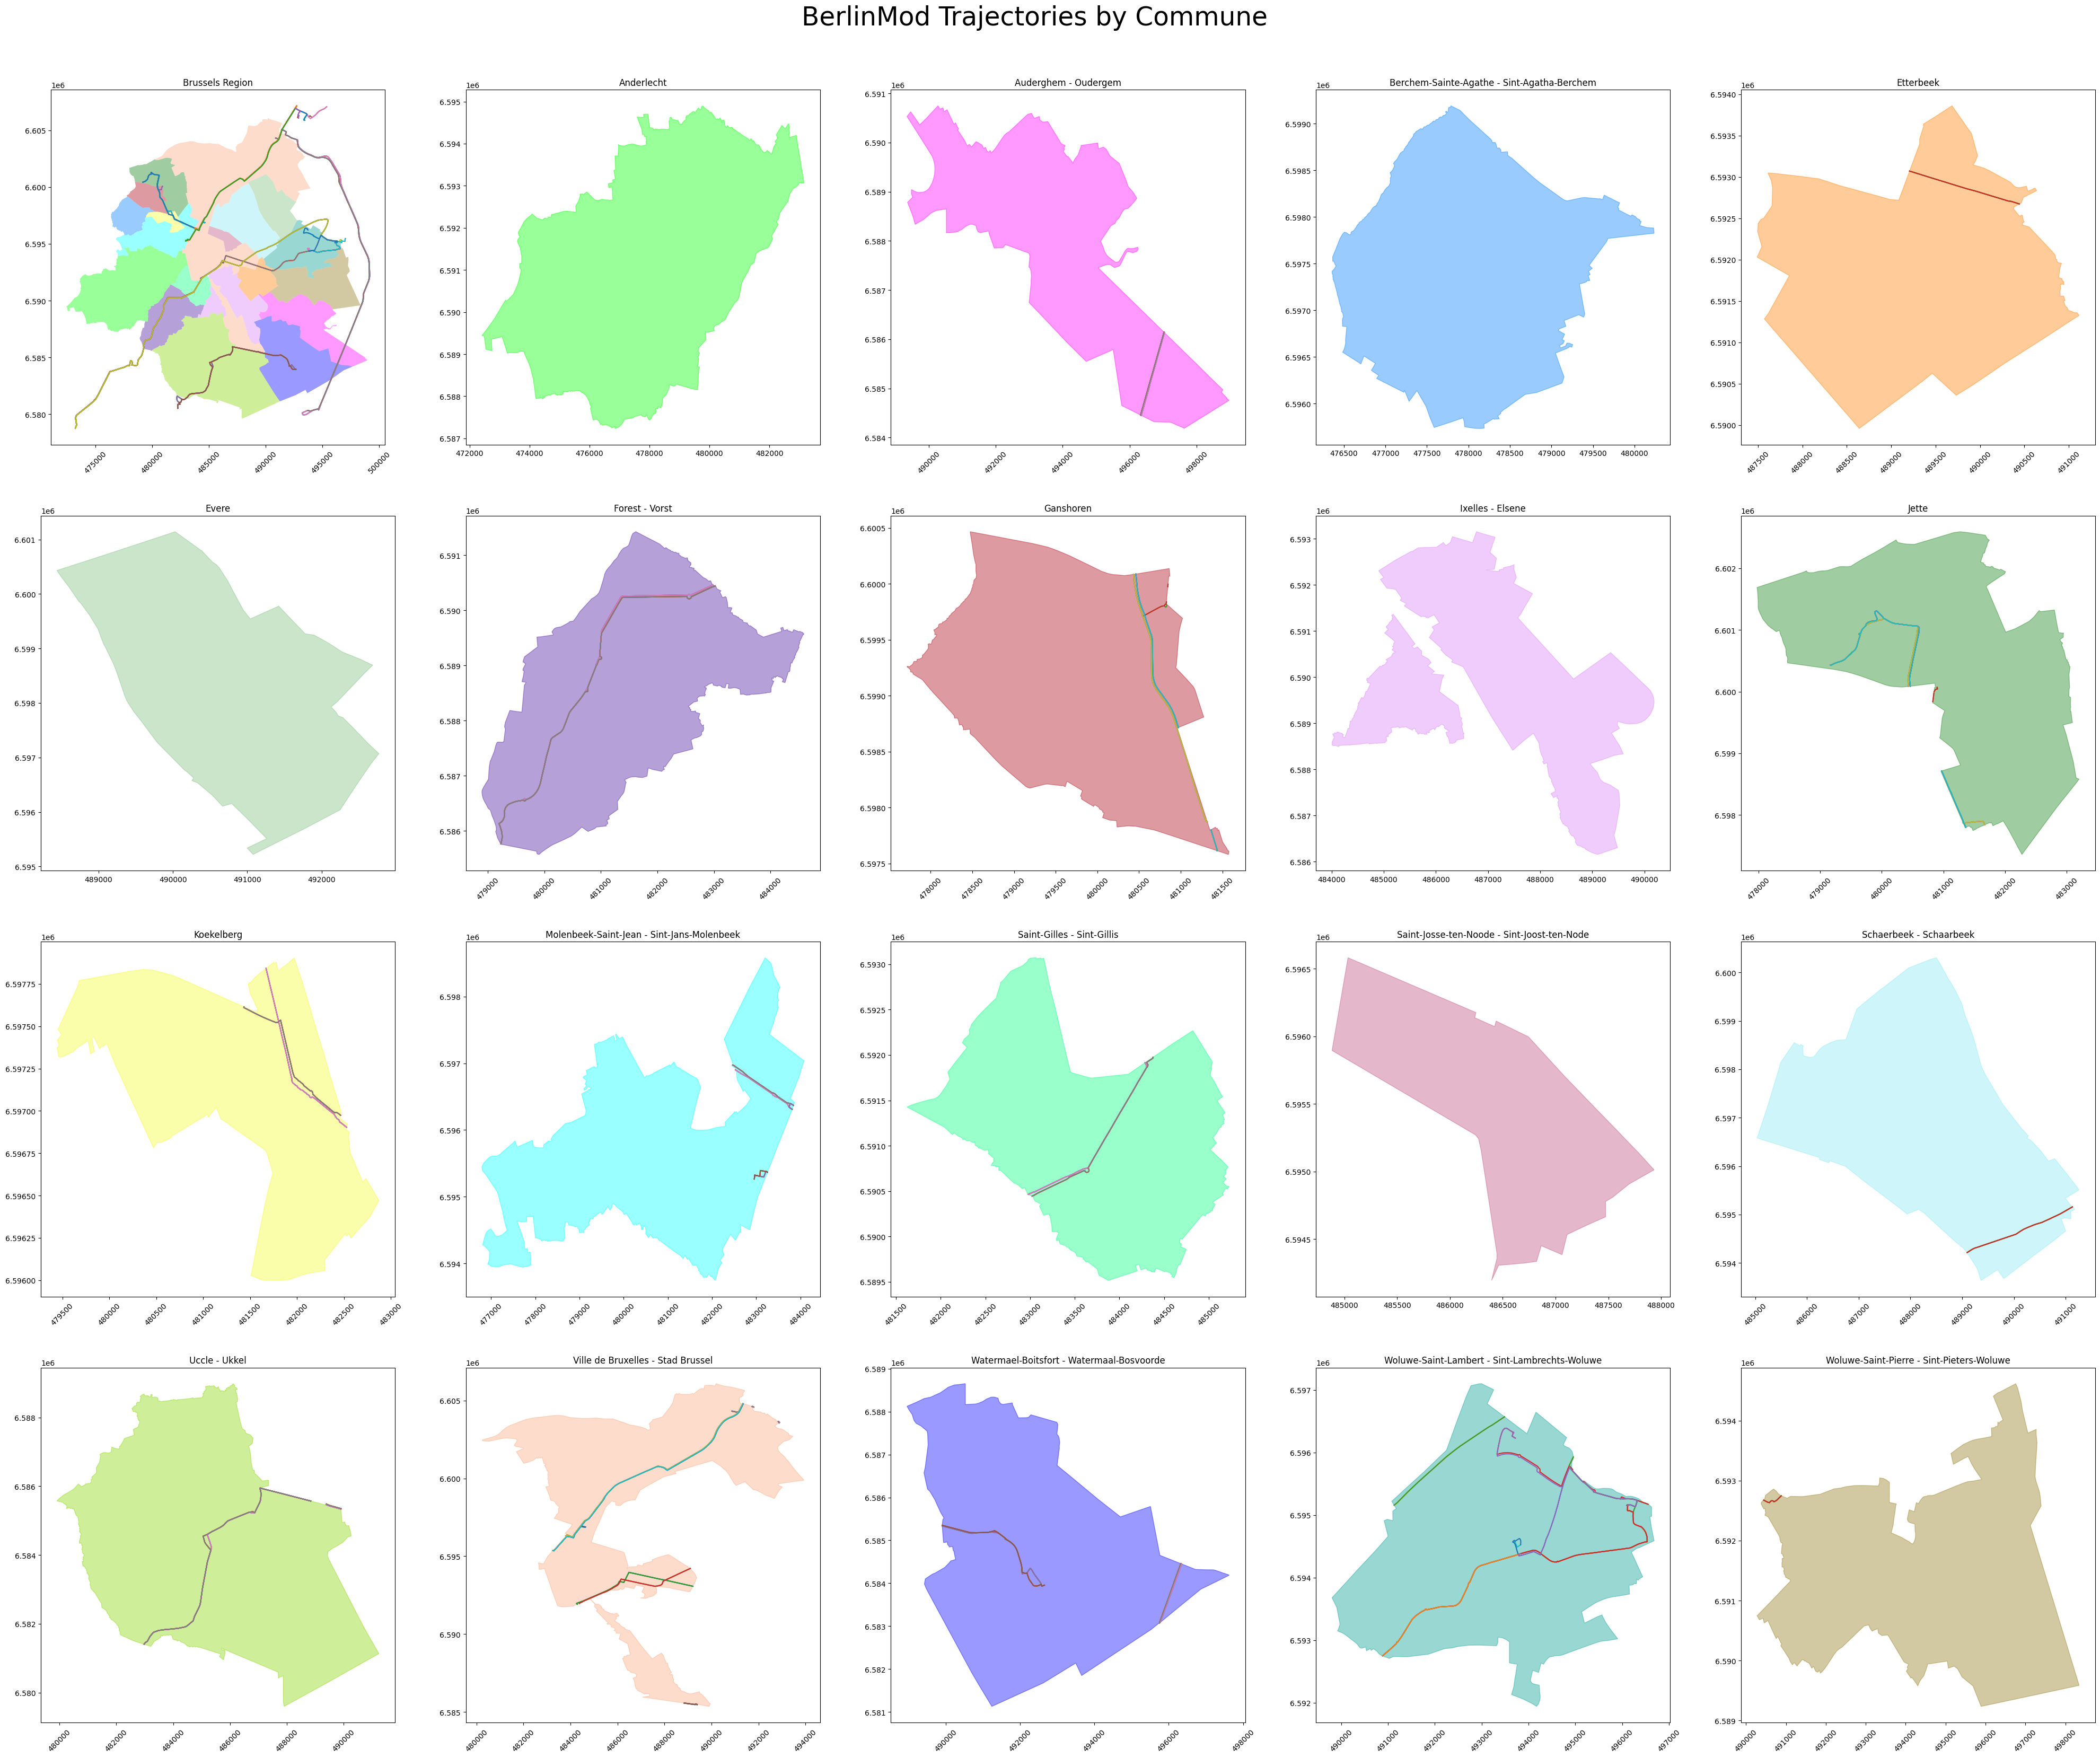

In [17]:
_, axes = plt.subplots(4, 5, figsize=(50, 40))

axes[0][0].set_title('Brussels Region')
communes.plot(color=communes['color'], ax=axes[0][0], alpha=0.4)
TemporalPointSequencePlotter.plot_sequences_xy(trips['trip'], axes=axes[0][0], show_markers=False, show_grid=False)

for i, commune in communes.iterrows():
    ax = axes[(i + 1) // 5][(i + 1) % 5]
    ax.set_title(commune['name'])
    # Plot commune
    if isinstance(commune['geom'], shp.Polygon):
        ax.fill(*commune['geom'].exterior.xy, color=commune['color'], alpha=0.4)
    else:
        for g in commune['geom'].geoms:
            ax.fill(*g.exterior.xy, color=commune['color'], alpha=0.4)
    # Plot trajectories
    trajs = commune_trajectories[f'{commune["name"]}-trajectory'].dropna()
    for tr in trajs:
        TemporalPointSequenceSetPlotter.plot_xy(tr, axes=ax, show_markers=False, show_grid=False)

_ = plt.suptitle('BerlinMod Trajectories by Commune', size=35, y=0.92)

## Simplifying Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_simplify_berlinmod/))

In this section, we will simplify the trajectories with two different methods, namely Douglas-Peucker (DP) and Syncronized Euclidean Distance (SED, aka Top-Down Time Ratio simplification), and compare the simplifications.

First, we'll choose a distance tolerance to use in the simplification

In [55]:
tolerance = 20

Now, we'll compute both simplifications with the `simplify` method

In [56]:
simplifications = trips.copy()
simplifications['dp'] = simplifications['trip'].apply(lambda trip: trip.simplify(tolerance))
simplifications['sed'] = simplifications['trip'].apply(lambda trip: trip.simplify(tolerance, synchronized=True))
simplifications.head()

vehicle         day  seq  \
0        1  2020-06-01    1   
1        1  2020-06-01    2   
2        1  2020-06-02    1   
3        1  2020-06-02    2   
4        1  2020-06-03    1   

                                                trip  \
0  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
1  [010100000036A6A116E0F51D410818EC5287315941@20...   
2  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
3  [010100000036A6A116E0F51D410818EC5287315941@20...   
4  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   

                                                  dp  \
0  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
1  [010100000036A6A116E0F51D410818EC5287315941@20...   
2  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   
3  [010100000036A6A116E0F51D410818EC5287315941@20...   
4  [0101000000A5218194E3211E41EB9B43431A1A5941@20...   

                                                 sed  
0  [0101000000A5218194E3211E41EB9B43431A1A5941@20...  
1  [010100000036A6A116E0F51D410818EC5287315941@20...  
2  [0101000000A5218194E3211E41EB9B43431A1A5941@20...  
3  [010100000036A6A116E0F51D410818EC5287315941@20...  
4  [0101000000A5218194E3211E41EB9B43431A1A5941@20...

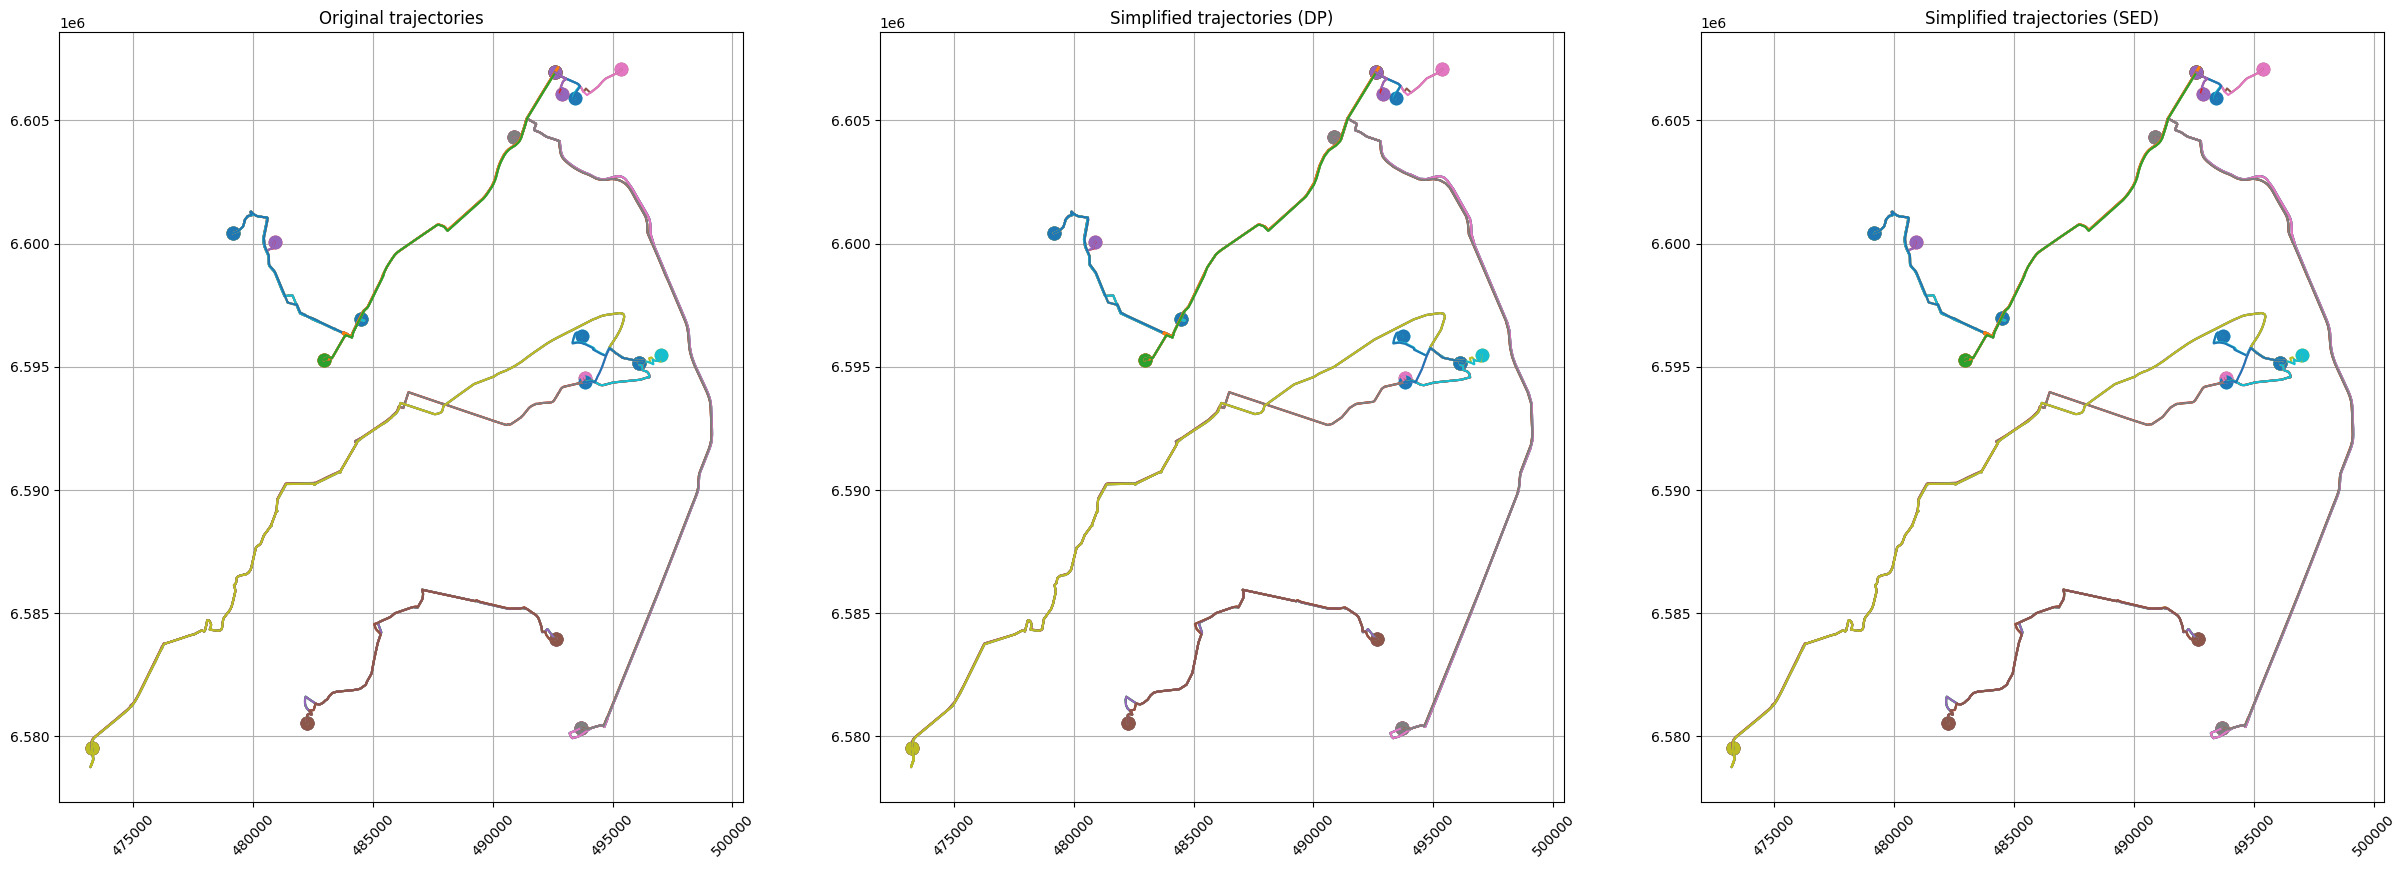

In [57]:
_, axes = plt.subplots(1, 3, figsize=(30, 10))
for _, trip in simplifications.iterrows():
    trip['trip'].plot(axes=axes[0])
    trip['dp'].plot(axes=axes[1])
    trip['sed'].plot(axes=axes[2])
axes[0].set_title('Original trajectories')
axes[1].set_title('Simplified trajectories (DP)')
axes[2].set_title('Simplified trajectories (SED)')
plt.show()

Let's focus on only one trajectory to see the simplification more clearly

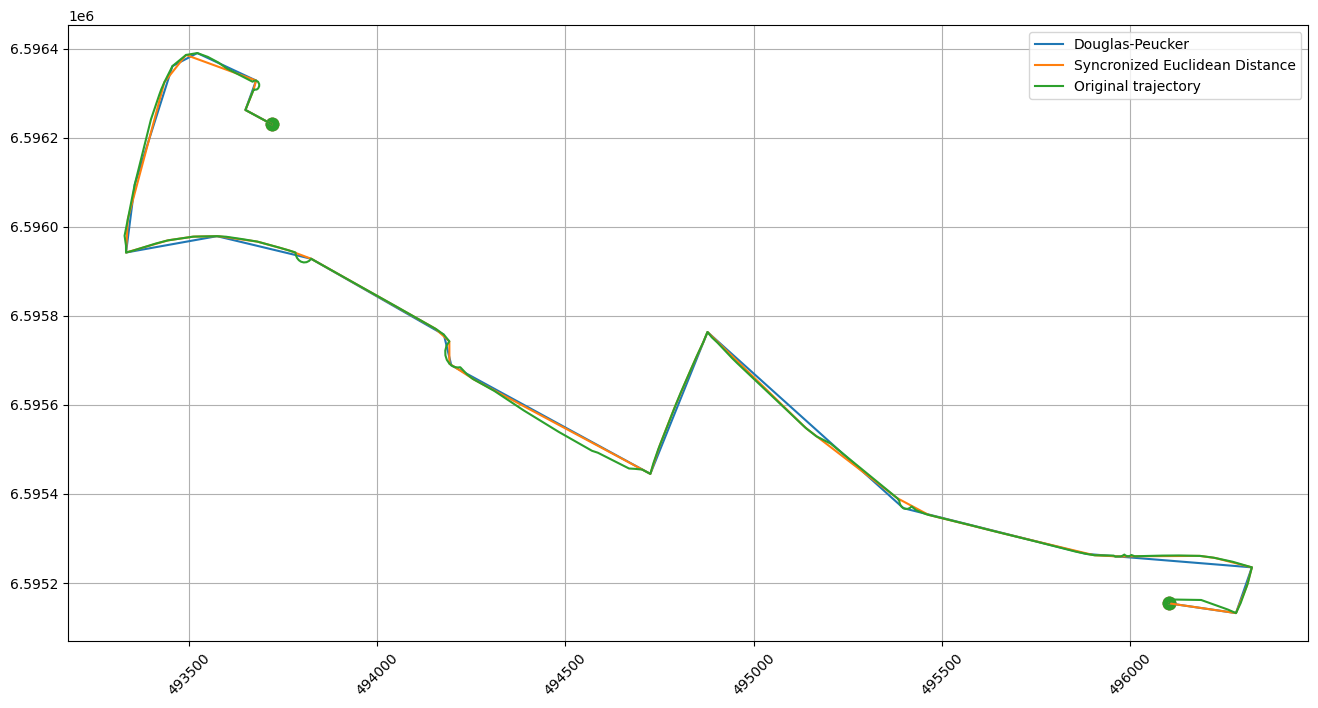

In [58]:
trip = simplifications.iloc[20]
fig, ax = plt.subplots(figsize=(16, 8))
trip['dp'].plot(label='Douglas-Peucker')
trip['sed'].plot(label='Syncronized Euclidean Distance')
trip['trip'].plot(label='Original trajectory')
plt.legend()
plt.show()

Now, let's see the difference in points in each trajectory with their simplifications

In [67]:
distances = simplifications[['vehicle', 'day', 'seq']].copy()
distances['trip'] = simplifications['trip'].apply(lambda trip: trip.num_instants)
distances['dp'] = simplifications['dp'].apply(lambda trip: trip.num_instants)
distances['sed'] = simplifications['sed'].apply(lambda trip: trip.num_instants)
distances['dp-delta'] = distances['trip'] - distances['dp']
distances['sed-delta'] = distances['trip'] - distances['sed']
distances['dp-%'] = distances['dp'] * 100 / distances['trip']
distances['sed-%'] = distances['sed'] * 100 / distances['trip']
distances.head()

vehicle         day  seq  trip  dp  sed  dp-delta  sed-delta      dp-%  \
0        1  2020-06-01    1  2473  47  324      2426       2149  1.900526   
1        1  2020-06-01    2  2420  40  312      2380       2108  1.652893   
2        1  2020-06-02    1  2482  47  314      2435       2168  1.893634   
3        1  2020-06-02    2  2281  40  304      2241       1977  1.753617   
4        1  2020-06-03    1  2470  47  329      2423       2141  1.902834   

       sed-%  
0  13.101496  
1  12.892562  
2  12.651088  
3  13.327488  
4  13.319838

We can see in the following table that the DP-simplified trips contain only a 3% of the original points in average, and that the SED-simplified ones around a 10%.

In [68]:
distances[['dp-delta', 'dp-%', 'sed-delta', 'sed-%']].describe()

dp-delta       dp-%    sed-delta      sed-%
count    55.000000  55.000000    55.000000  55.000000
mean   1347.763636   3.012138  1228.909091  10.921927
std     911.609382   1.015390   821.201181   1.358796
min      92.000000   1.652893    86.000000   8.433735
25%     502.000000   2.517154   476.500000   9.996257
50%    1103.000000   2.783049  1008.000000  10.791367
75%    2337.000000   3.363105  2066.000000  11.828472
max    3125.000000   7.070707  2846.000000  13.368984

## Temporal Aggregation of Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_aggregate_berlinmod/))

In this section we will aggregate the trips to calculate the extent (the spatiotemporal bounding box) and the temporal count (the evolution on time of the number of vehicles travelling).

## Tiling Trips ([MEOS Example](https://libmeos.org/tutorialprograms/meos_tile_berlinmod/))

In this section, the trajectories and the speed will be split into tiles, for which we will compute some aggregates.